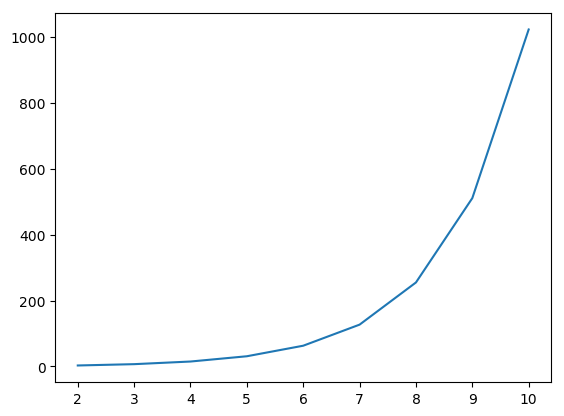

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.reset_defaults()
from scipy import special

plt.plot(range(2,11),[sum(special.binom(k,1+j) for j in range(k)) for k in range(2,11)])

## make_classification

In [143]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from secoc import estimator; reload(estimator)
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, make_blobs
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(centers=4, n_samples=1000, n_features=100, cluster_std=30)

In [144]:
train_index, test_index = next(StratifiedShuffleSplit(n_splits=1, test_size=.2).split(X, y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
# X_train_small = X_train
# y_train_small = y_tr

In [152]:
reload(estimator)
from sklearn.tree import DecisionTreeClassifier
est = estimator.SlidingECOC(
    LogisticRegression(), n_estimators_window=20, window_size=25,
    oob_score=True, code_size=2000, single_seed_features=True, single_seed_samples=True,
    circular_features=True, random_state=None,
    n_estimators=None, stride=1, max_features=1., max_samples=.5,
    bootstrap_features=False, bootstrap=False, verbose=1, n_jobs=-1).fit(
        X_train, y_train)
encoding = est.encode(X_train)

You are about to generate 20 estimators for 100 windows, for a total of 2000 estimators.


[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    1.5s remaining:   10.5s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    2.3s finished


In [153]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(metric='hamming', algorithm='brute', n_jobs=-1, n_neighbors=5)
code_range = map(int, np.linspace(10,1000, 100))
tr_score, ts_score = [], []
for code_size in code_range:
    y_pred = est.predict(X_test, classifier=clf, code_size=code_size)
    ts_score.append(accuracy_score(y_test, y_pred))
    y_pred = est.predict(X_train, classifier=clf, code_size=code_size)
    tr_score.append(accuracy_score(y_train, y_pred))

In [154]:
X_small_train = X_train[est.estimators_samples_[0]]
y_small_train = y_train[est.estimators_samples_[0]]
lr = LogisticRegression().fit(X_small_train, y_small_train)
base_train_score_logistic = lr.score(X_train, y_train)
base_test_score_logistic = lr.score(X_test, y_test)

In [155]:
from sklearn.ensemble import BaggingClassifier
X_small_train = X_train[est.estimators_samples_[0]]
y_small_train = y_train[est.estimators_samples_[0]]
bc = BaggingClassifier(LogisticRegression(), n_estimators=2000, max_samples=.5, max_features=1.0,
                  bootstrap=False, bootstrap_features=False, oob_score=0, warm_start=False, n_jobs=-1)
bc.fit(X_small_train, y_small_train)
base_train_score = bc.score(X_train, y_train)
base_test_score = bc.score(X_test, y_test)

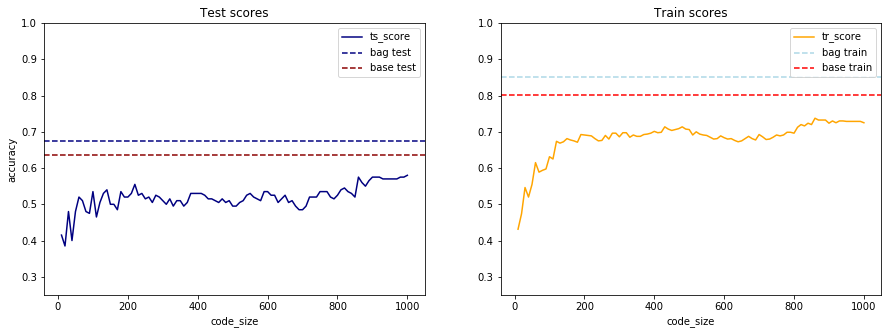

In [156]:
plt.figure(figsize=(15,20));
f, ax = plt.subplots(1,2, figsize=(15,5));

ax[0].plot(code_range, ts_score, label="ts_score", c='navy');
ax[1].plot(code_range, tr_score, label="tr_score", c='orange');

ax[1].axhline(base_train_score, label='bag train', c='lightblue', ls='--');
ax[0].axhline(base_test_score, label='bag test', c='navy', ls='--');
ax[1].axhline(base_train_score_logistic, label='base train', c='red', ls='--');
ax[0].axhline(base_test_score_logistic, label='base test', c='darkred', ls='--');

ax[0].set_title("Test scores");
ax[1].set_title("Train scores");
ax[0].set_xlabel("code_size");
ax[1].set_xlabel("code_size");
ax[0].set_ylabel("accuracy");
ax[0].legend();
ax[1].legend();
ax[0].set_ylim([0.25,1])
ax[1].set_ylim([0.25,1])

plt.show()

In [44]:
accuracy_score(y_test, y_pred)

0.81000000000000005

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=850).fit(X_train_small, y_train_small)

rfc.score(X_test, np.where(y_test)[1])

0.94479999999999997

In [49]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
def visualise(X, y, title=''):
#     tr = TSNE(n_components=2).fit_transform(X)
    tr = PCA(n_components=2).fit_transform(X)
    for i in np.unique(y):
        plt.plot(tr[y == i,0],tr[y == i,1], 'o', label=i)
        
    plt.legend(bbox_to_anchor=(0., -.252, 1., .102), loc='lower center',
           ncol=5, mode="expand", borderaxespad=0.)
    plt.title(title)
    plt.show()

In [50]:
encoding.shape

(160, 2000)

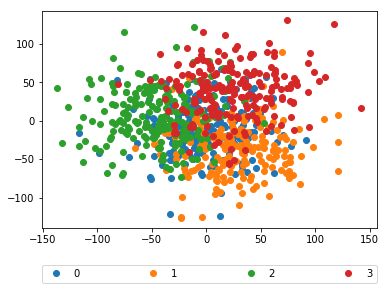

In [151]:
visualise(X_train, y_train)

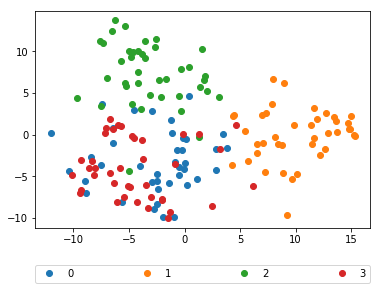

In [72]:
visualise(encoding, y_train)

In [ ]:
visualise(encoding, y_train_small, "encoding")

In [ ]:
visualise(X_train_small, y_train_small, "CNN features")

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def visualise_lda(X, y):
    tr = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
    for i in np.unique(y):
        plt.plot(tr[y == i,0],tr[y == i,1], 'o', label=i)
        
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=5, mode="expand", borderaxespad=0.)
    plt.show()

/home/fede/miniconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


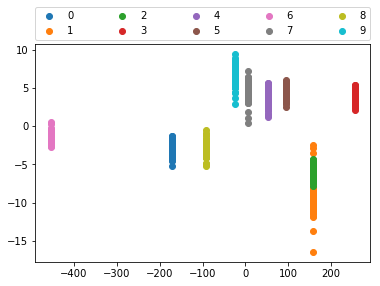

In [48]:
visualise_lda(X_train_small, y_train_small)

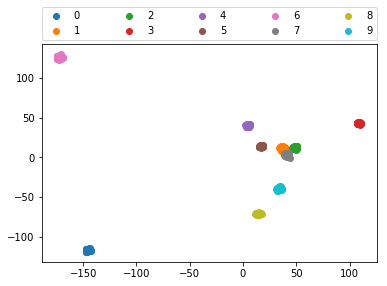

In [49]:
visualise_lda(encoding, y_train_small)